In [19]:
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import models, transforms

In [2]:
"""Specify which device (CPU or GPU) to use"""

if torch.cuda.is_available():  # if we have a GPU and its available to pytorch, use it
    device = torch.device("cuda")
    torch.set_default_device(device)
    print(f"Using GPU device: {torch.cuda.get_device_name(device)}\n")
else:  # else, use cpu
    device = torch.device("cpu")
    print("Using CPU.\n")

Using GPU device: NVIDIA GeForce RTX 3090



In [3]:
"""Initialize target outputs: read our labels from a file and convert them to a 2-d tensor."""

labels_path = Path(r"C:\Users\jai\veo_nu\data\labels\Initial_combined_labels.csv")  # path to labels file
labels_df = pd.read_csv(labels_path)  # read the labels file into a pandas dataframe table
display(labels_df.head())  # display the first few rows of the labels dataframe

,Frame,Possession,Set piece
0,410,1,0
1,420,1,0
2,430,1,0
3,440,1,0
4,450,1,0


In [4]:
Y = labels_df[["Possession", "Set piece"]].values  # extract the "Possession" and "Set piece" values
Y = torch.from_numpy(Y).float().to(device)  # convert the extracted values to a 2-d tensor
print(Y.shape)  # print the shape of the initialized target outputs
N, n_classes = Y.shape[0], Y.shape[1]  # number of samples (total number of combined labeled frames)

torch.Size([680, 2])


In [5]:
"""Initialize inputs: convert the frame images to a list of 3-d tensors (width X height X rgb)."""

frames_path = Path(r"C:\Users\jai\veo_nu\data\initial_combined_frames")  # path to image directory
n_channels, height, width = 3, 224, 224  # initialize the dimensions of the frames
X = torch.empty((N, n_channels, height, width))  # initialize a tensor that will store all frames
print(X.shape)  # print shape of initialized inputs

torch.Size([680, 3, 224, 224])


In [6]:
for i, file in enumerate(frames_path.glob("*.png")):  # find each image file in `frames_path` directory
    with Image.open(file).convert("RGB") as img:  # open the image file and convert to RGB
        to_tensor = transforms.ToTensor()  # initialize a ToTensor conversion object
        resize = transforms.Resize((height, width))  # initialize a Resize object
        img_tensor = to_tensor(img).float()  # use the ToTensor object to convert the image to a tensor
        img_tensor = resize(img_tensor)
        X[i, :] = img_tensor  # add the tensor of the current frame to our list of tensors

c:\Users\jai\mambaforge\envs\intro2dl\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [7]:
"""Create Dataset and DataLoader."""

generator = torch.Generator(device)

dataset = TensorDataset(X, Y)
train_data, test_data, val_data = random_split(dataset, [0.85, 0.075, 0.075], generator=generator)
X_train, Y_train = train_data[:][0], train_data[:][1]
X_test, Y_test = test_data[:][0], test_data[:][1]
X_val, Y_val = val_data[:][0], val_data[:][1]

In [8]:
"""Create function to perform gradient centralization during trainingS."""

def apply_gradient_centralization(optimizer):
    """Applies gradient centralization to the optimizer.
    
    This function should be called before optimizer.step() in the training loop.
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                # Compute the mean of the gradient
                grad_mean = param.grad.data.mean(dim=tuple(range(1, len(param.grad.shape))), keepdim=True)
                # Centralize the gradient
                param.grad.data -= grad_mean

In [30]:
"""Create function to train the model."""

def train(
    model: nn.Module,  # model
    train_loader: DataLoader,  # batched dataset for training
    val_loader: DataLoader,  # batched dataset for validation
    optimizer: optim,  # optimizer
    loss_fn: nn.modules.loss,  # loss function
    max_epochs: int = 5,  # max n training epochs
    val_check_interval: int = 10,  # check val loss every `val_check_interval` batches
    patience_thresh: int = 1e9,  # `patience_thresh * val_check_interval` batches early stop check
    print_loss_interval: int = 10,  # print loss every `print_loss` batches
) -> tuple[torch.Tensor, np.ndarray, np.ndarray]:  # -> loss, train_losses, val_losses
    """Trains a model, returns loss."""
    # Trackers
    best_val_loss, val_loss = np.inf, np.inf
    patience_ct = 0
    train_losses = np.zeros((max_epochs + 1) * len(train_loader))
    train_losses_i = 0
    val_losses = np.zeros((max_epochs + 1) * len(train_loader) // val_check_interval)
    val_losses_i = 0

    for epoch in range(max_epochs):
        for i, (x_train, y_train) in enumerate(train_loader):
            # <ss Model training.
            model.train()
            optimizer.zero_grad()
            out = model(x_train)
            loss = loss_fn(out, y_train)
            loss.backward()
            apply_gradient_centralization(optimizer)
            optimizer.step()
            if print_loss_interval and i % print_loss_interval == 0:
                print(f"Epoch {epoch + 1}:  Batch {i + 1}: {loss.item()=}  {val_loss=}")
            train_losses[train_losses_i], train_losses_i = loss.item(), val_losses_i + 1
            # /ss>
            # <ss Model validation (for early stopping).
            if i % val_check_interval == 0:
                model.eval()
                with torch.no_grad():
                    x_val, y_val = next(iter(val_loader))
                    val_loss = loss_fn(model(x_val), y_val).item()
                    patience_ct = 0 if val_loss < best_val_loss else patience_ct + 1
                    best_val_loss = min(best_val_loss, val_loss)
                    val_losses[val_losses_i], val_losses_i = val_loss, val_losses_i + 1
                if patience_ct >= patience_thresh:
                    print("Early stopping.")
                    print(f"Epoch {epoch + 1}:  Batch {i + 1}: {loss.item()=}  {val_loss=}")
                    return loss, train_losses[train_losses != 0], val_losses[val_losses != 0]
            # /ss>
    print("Finished training:")
    print(f"Epoch {epoch + 1}:  Batch {i + 1}: {loss.item()=}  {val_loss=}")
    return loss, train_losses[train_losses != 0], val_losses[val_losses != 0]

In [31]:
"""Load in initial pretrained model."""

# Possible pretrained models to try: DenseNet121_Weights, DenseNet169_Weights, ResNet50_Weights, ResNet101_Weights

model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
print(model)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [32]:
"""Configure model"""

dropout_rate = 0.2

# Modify the classifier to output 2 probabilities
model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.classifier.in_features, n_classes),
    nn.Sigmoid()  # Use sigmoid for binary multiclass, multilabel classification
)

In [33]:
"""Train model."""

shuffle = True if device == "cpu" else False
batch_size = 32
learning_rate = 0.02

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=shuffle)
# Set loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-7, momentum=0.5, nesterov=True)
# Train
loss, train_losses, val_losses = train(
    model, train_loader, val_loader, optimizer, loss_fn, max_epochs=10,
)

Epoch 1:  Batch 1: loss.item()=0.7420353889465332  val_loss=inf
Epoch 1:  Batch 11: loss.item()=0.3380955457687378  val_loss=0.4973980188369751
Epoch 2:  Batch 1: loss.item()=0.26791051030158997  val_loss=0.29260337352752686
Epoch 2:  Batch 11: loss.item()=0.15262550115585327  val_loss=0.27364808320999146
Epoch 3:  Batch 1: loss.item()=0.15019291639328003  val_loss=0.13899581134319305
Epoch 3:  Batch 11: loss.item()=0.07707980275154114  val_loss=0.14772532880306244
Epoch 4:  Batch 1: loss.item()=0.161460742354393  val_loss=0.08110988140106201
Epoch 4:  Batch 11: loss.item()=0.05573001503944397  val_loss=0.13135933876037598
Epoch 5:  Batch 1: loss.item()=0.04334762319922447  val_loss=0.04824433475732803
Epoch 5:  Batch 11: loss.item()=0.03808610886335373  val_loss=0.16142503917217255
Epoch 6:  Batch 1: loss.item()=0.027694610878825188  val_loss=0.04476705193519592
Epoch 6:  Batch 11: loss.item()=0.03438441455364227  val_loss=0.06904316693544388
Epoch 7:  Batch 1: loss.item()=0.019628178

Text(0.5, 1.0, 'Training and Validation Losses')

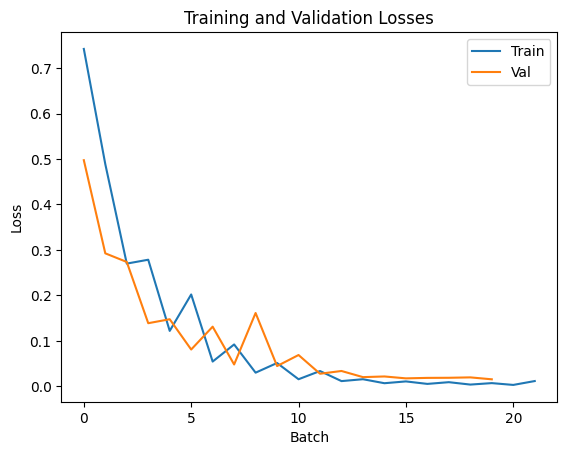

In [34]:
# Plot training and validation losses
fig, ax = plt.subplots()
ax.plot(train_losses, label="Train")
ax.plot(val_losses[0:len(train_losses)], label="Val")
ax.legend()
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Losses")
